# Palmprint Recognition Network (PRN)

In this notebook, one can test the functionality of the recognition network. 
Therefore install the environment.yaml file and you are ready to go!

The whole Network is tested on the Tongji - Full palmprint dataset

In [1]:
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function, Variable
from torchvision import transforms, models
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
import itertools
import matplotlib.pyplot as plt
import time
from PIL import Image, ImageDraw, ImageFont
import copy
torch.set_default_dtype(torch.float64)
import numpy as np
import cv2

from networks.ROILAnet import ROILAnet
from networks.TPSGridGen import TPSGridGen

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
ROIModelPath = 'weights/ROI_extractor_augmented_TJ-NTU.pt' # path to pretrained network weights
CNNModelPath = 'weights/resnet18_tongji_unfreezed_extractor.pt'

In [4]:
# for tongji we have 600 different palm of 300 different persons
class_names = []
for i in range(600):
    class_names.append(f'user_{i}')

## Defnition of Loaders

In [5]:
def loadROIModel(weightPath: str = None):
    """
    @weightPath: path to the ROILAnet() weights
    loads localization network with pretrained weights
    """
    model = ROILAnet()
    model.load_state_dict(torch.load(weightPath, map_location=torch.device(device)))
    model = model.to(device)
    model.eval()
    model.requires_grads=False
    return model

In [6]:
def getThinPlateSpline(target_width: int = 112, target_height: int = 112) -> torch.Tensor:
    """
    @target_width: desired I_ROI output width
    @target_height: desired I_ROI output height
    greates instance of TPS grid generator
    """
    # creat control points
    target_control_points = torch.Tensor(list(itertools.product(
        torch.arange(-1.0, 1.00001, 1.0),
        torch.arange(-1.0, 1.00001, 1.0),
    )))
    gridgen = TPSGridGen(target_height=target_height, target_width=target_width, target_control_points=target_control_points)
    gridgen = gridgen.to(device)
    return gridgen

In [7]:
def getOriginalAndResizedInput(path: str = None) -> (np.ndarray, torch.Tensor, torch.Tensor):
    """
    @path: image which should be loaded from database
    This function load the image of variable size from a directory given in path.
    After doing the resizing to 56x56 pixels, the original and resized image will be returned
    as (PILMain, source_image, resizedImage) triplet
    """
    if path is None:
        return (None, None)
    
    #define transformer for resized input of feature extraction CNN
    resizeTranformer = transforms.Compose([
            transforms.Resize((56,56)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    PILMain = Image.open(path).convert(mode = 'RGB') # load image in PIL format
    sourceImage = np.array(PILMain).astype('float64') # convert from PIL to float64
    sourceImage = transforms.ToTensor()(sourceImage).unsqueeze_(0) # add first dimension, which is batch dim
    sourceImage = sourceImage.to(device) # load to available device

    resizedImage = resizeTranformer(PILMain)
    resizedImage = resizedImage.view(-1,resizedImage.size(0),resizedImage.size(1),resizedImage.size(2))
    resizedImage = resizedImage.to(device) # load to available device
    return (PILMain, sourceImage,resizedImage)

In [8]:
def getThetaHat(resizedImage: torch.Tensor = None, model = None) -> torch.Tensor: 
    """
    @resizedImage: cropped image
    @model: ROI Localisation network, which outputs a theta vector
    resizedImage: image which should is loaded from database via getOriginalAndResizedInput function
    Here the theta vector is calculated using the pretrained localisation network. The vector has a size of
    [9, 2] -> which stand for 9 pairs of x and y values
    """
    if resizedImage is None:
        return None
    
    with torch.no_grad(): # deactivate gradients because we try to predict the ROI
        theta_hat = model.forward(resizedImage)
    theta_hat = theta_hat.view(-1, 2, 9) # split into x and y vector -> theta_hat is originally a vector like [xxxxxxxxxyyyyyyyyy]
    theta_hat = torch.stack((theta_hat[:,0], theta_hat[:,1]),-1)
    return theta_hat

In [9]:
def sampleGrid(theta_hat: torch.Tensor = None, sourceImage: torch.Tensor = None, target_width: int = 112, target_height: int = 112 ) -> torch.Tensor:
    """
    @theta_hat: theta vector of normlized x,y coordinate pairs
    @sourceImage: the original image without any crops or resizsing
    @target_width: output IROI target width
    @target_height: output IROI target height
    Samples grid from a given theta vector, source image and grid generator
    """
    gridgen = getThinPlateSpline(target_width, target_height)
    #generate grid from calculated theta_hat vector
    source_coordinate = gridgen(theta_hat)
    #create target grid - with target height and target width
    grid = source_coordinate.view(-1, target_height, target_width, 2).to(device)
    #sample ROI from input image and created T(theta_hat)
    target_image = F.grid_sample(sourceImage, grid,align_corners=False)
    return target_image

In [10]:
def printExtraction(target_image: torch.Tensor = None, source_image = None):
    """
    @source_image: prints the source_image which is in the PIL format
    @target_image: print the target_image which is a tensor (ROI)
    """
    #prepare to show -> get back from gpu if needed
    target_image = target_image.cpu().data.numpy().squeeze().swapaxes(0, 1).swapaxes(1, 2)
    target_image = Image.fromarray(target_image.astype('uint8'))
    plt.imshow(source_image)
    plt.show() # show original image
    plt.imshow(target_image)
    plt.show() # show ROI

In [11]:
def loadCNNModel(weightPath: str = None):
    """
    @weightPath: path to the ROILAnet() weights
    loads localization network with pretrained weights
    """
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))
    model.load_state_dict(torch.load(weightPath, map_location=torch.device(device)))
    model.to(device)
    return model

In [12]:
def getIROI(model, input):
    resizedImage = F.interpolate(input, (56, 56))
    theta_hat = getThetaHat(resizedImage=resizedImage, model=model) # create theta hat with normlized ROI coordinates
    IROI = sampleGrid(theta_hat=theta_hat, sourceImage=input, target_width=224, target_height=224) # get ROI from source image
    IROI.to(device)
    return IROI

In [13]:
def markImage(image, theta):
    nimg = np.array(image)
    ocvim = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    for idx, coord in enumerate(theta):
        currX = coord[0]
        currY = coord[1]
        x = int((ocvim.shape[1] - 1) / (1 + 1) * (currX - 1) + ocvim.shape[1])
        y = int((ocvim.shape[0] - 1) / (1 + 1) * (currY - 1) + ocvim.shape[0])
        ocvim = cv2.circle(ocvim,(x,y),6,(200,0,0),2)
        ocvim = cv2.putText(
            ocvim,  # numpy array on which text is written
            str(idx),  # text
            (x, y),  # position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX,  # font family
            1,  # font size
            (209, 80, 0, 255),  # font color
            3)
    ocvim = ocvim[...,::-1]
    return ocvim

In [14]:
def getOriginalAndResizedInput(PILMain) -> (np.ndarray, torch.Tensor, torch.Tensor):
    """
    @path: image which should be loaded from database
    This function load the image of variable size from a directory given in path.
    After doing the resizing to 56x56 pixels, the original and resized image will be returned
    as (PILMain, source_image, resizedImage) triplet
    """
    if PILMain is None:
        return (None, None)
    
    #define transformer for resized input of feature extraction CNN
    resizeTranformer = transforms.Compose([
            transforms.Resize((56,56)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    #PILMain = PILMain.convert(mode = 'RGB') # load image in PIL format
    sourceImage = np.array(PILMain).astype('float64') # convert from PIL to float64
    sourceImage = transforms.ToTensor()(sourceImage).unsqueeze_(0) # add first dimension, which is batch dim
    sourceImage = sourceImage.to(device) # load to available device

    resizedImage = resizeTranformer(PILMain)
    resizedImage = resizedImage.view(-1,resizedImage.size(0),resizedImage.size(1),resizedImage.size(2))
    resizedImage = resizedImage.to(device) # load to available device
    return (PILMain, sourceImage,resizedImage)

In [15]:
#load localisation netowork
localisationNetwork = loadROIModel(ROIModelPath) # load localisation network

#recognition Network setup pretrained
recognitionNetwork = loadCNNModel(CNNModelPath)

# Prediction Area

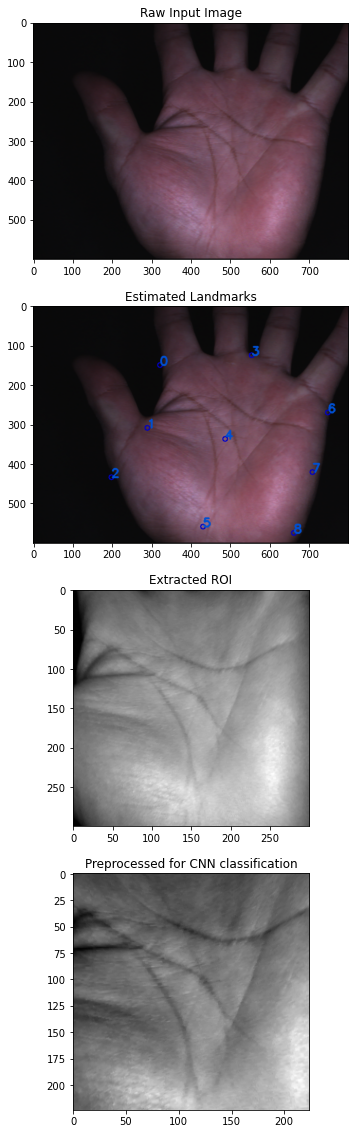

Probability of being correct: 100.00 %
Should be: user_0, predicted: user_0


In [16]:
def predictAndShow(path: str):
    """
    Single Image Prediction
    @path: path to hand image (Tongji)
    """
    grayTransformer = transforms.Compose([
                    transforms.CenterCrop((224,224)),
                    transforms.Grayscale(num_output_channels=3),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    CNNtransformer = transforms.Compose([
        transforms.Grayscale(),
        transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    plt.figure(figsize=(20,20)) # specifying the overall grid size
    recognitionNetwork.eval()
    #testing for user 0
    inputPIL = Image.open(path).convert('RGB')
    plt.subplot(4,1,1)
    plt.imshow(inputPIL)
    plt.title('Raw Input Image')
    classes=['user_0']
    (PILMain, sourceImage,resizedImage) = getOriginalAndResizedInput(inputPIL)
    sourceImage = torch.stack([sourceImage.squeeze()])
    resizedImage = torch.stack([resizedImage.squeeze()])
    #get normalized coordinates
    theta_hat = getThetaHat(resizedImage, localisationNetwork)
    plt.subplot(4,1,2)
    plt.imshow(markImage(inputPIL, theta_hat[0]))
    plt.title('Estimated Landmarks')
    #get all ROIs
    IROI = sampleGrid(theta_hat=theta_hat, sourceImage=sourceImage, target_width=300, target_height=300)
    IROI = IROI[0]
    plt.subplot(4,1,3)
    plt.imshow((IROI.cpu()[0]),cmap='gray')
    plt.title('Extracted ROI')
    b = Image.fromarray(np.uint8(IROI.cpu()[0])).convert('L')
    img = CNNtransformer(b)
    plt.subplot(4,1,4)
    plt.imshow((img.cpu()[0]),cmap='gray')
    plt.title('Preprocessed for CNN classification')
    img = img.view(1,img.size(0),img.size(1),img.size(2))
    img = img.to(device)
    with torch.no_grad():
        resp = recognitionNetwork.forward(img)
    m = nn.Softmax(dim=1)
    classi = m(resp)
    plt.show()

    print("Probability of being correct: {:.2f} %".format(classi.cpu().numpy().max()*100))
    print(f"Should be: {classes[0]}, predicted: {class_names[np.argmax(classi.cpu().numpy())]}")